## Setting up firebase

In [ ]:
# imports
import firebase_admin
from firebase_admin import credentials, firestore

# get the credential certificate from json file
cred = credentials.Certificate('jaynakum-experiments-88cc723f2db9.json')
# using the credentials initialize the firebase app
default_app = firebase_admin.initialize_app(cred, {'storageBucket': 'jaynakum-experiments.appspot.com'})
# initialize the database
db = firestore.client()

# initialize the main document reference
doc_ref = db.collection(u'CPU Scheduling')


## Generate gantt chart and output table

In [ ]:
# imports
from matplotlib import pyplot as plt
from firebase_admin import storage

# method to generate gantt chart
def generateGanttChart(ganttChart: list) -> None:
  # create a figure and a set of subplots
  fig, gnt = plt.subplots()

  # set x-axis limit from 0 to the last entry of gantt chart
  gnt.set_xlim(0, ganttChart[(len(ganttChart) - 1)]['Exit Time'] + 1)
  # set y-axis limit to 1 because the chart is one line only
  gnt.set_ylim(0, 1)

  # set labels for both the axis
  gnt.set_xlabel('Time')
  gnt.set_ylabel('Process ID')

  # set y ticks and set labels = '' because there is no need to display it
  gnt.set_yticks([10, 20])
  gnt.set_yticklabels(['', ''])

  # the chart alternates between green and blue color
  # _isGreen flag is used to determine the color of broken_barh [broken bar horizontal]
  _isGreen = True
  for gantt in ganttChart:
    # _isGreen alternates between true and false
    _isGreen = not _isGreen
    # if true draw with green color else draw with blue
    if(_isGreen):
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4), facecolors=('tab:green'))
    else:
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4))
    # annotate the chart with the process' ID
    gnt.annotate(gantt['Process ID'], (gantt['Start Time'] + 0.2, 9.7))

  # save the output file
  plt.savefig('output/ganttChart.png')
  fileName = 'output/ganttChart.png'
  # print('Gantt Chart generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)

# method to generate output table
def generateOutput(outputProcesses: list, avgWT: int, avgTAT: int) -> None:
  # initializing a list of column lables
  columnLables = [
    'Process ID',
    'Arrival Time',
    'Burst Time',
    'Waiting Time',
    'Completion Time',
    'Turn Around Time',
    'Response Time'
  ]

  # making a list of each row(as list) from output 
  values = [[outputProcesses[i]['Process ID'], outputProcesses[i]['Arrival Time'], outputProcesses[i]['Burst Time'], outputProcesses[i]['Waiting Time'], outputProcesses[i]['Completion Time'], outputProcesses[i]['Turn Around Time'], outputProcesses[i]['Response Time']]for i in range(0, len(outputProcesses))]

  # set size and layout of output figure
  plt.rcParams["figure.figsize"] = [11.0, 3.0]
  plt.rcParams["figure.autolayout"] = True
  # create a figure and a set of subplots
  fig, table = plt.subplots()
  
  # turn off x and y axis
  table.set_axis_off()
  # enter the data into the table
  # cellText = values and colLabels = columnLabels with location center
  outputTable = table.table(cellText=values, colLabels=columnLables, cellLoc='center', loc='center')
  # scale the output image
  outputTable.scale(1.5, 1.5)
  # print 'Average Waiting Time' and 'Average Turn Around Time' in the image
  table.set_title('Average Waiting Time = ' + str(avgWT) + '\nAverage Turn Around Time = ' + str(avgTAT))

  # save the output file
  plt.savefig('output/outputTable.png')
  fileName = 'output/outputTable.png'
  # print('Output Table generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)


## Round Robin

In [ ]:
class RoundRobin:
  def __init__(self, processes, QUANTUM) -> None:
    
    self.processes = processes
    self.processCount = len(self.processes)
    self.QUANTUM = QUANTUM
    self.ganttChart = [] # the main list which will contain the ganttChart 
  
  # This method does the execution of the the process and generates a Gantt Chart
  def simulate(self) -> None: # and returns a ganttChart
    
    isDone = False
    time = 0 # initial startTime
    i = 0 # starting with process[0]

    while not isDone:
      if(i >= self.processCount):
        i = 0

      if(self.processes[(self.processCount-1)]['Burst Time'] == 0): # if the remaining burst time of last process is zero
        isDone = True # then gantt chart is formed
            
      # remainingBurstTime is the time left to execute
      remainingBurstTime = self.processes[i]['Burst Time'] # initially the burst time will be the remainingBurstTime
            
      if(remainingBurstTime == 0): # if the remaining time is zero
        i += 1 # then we skip to the next process
        continue
      
      # Check if there is an empty state
      while(self.processes[i]['Arrival Time'] > time):
        time += 1 # keep CPU empty
            
      ganttStart = time # note the start time before execution begins

      # performing the execution of process
      for _ in range(0, self.QUANTUM): # executing the process for given Time (QUANTUM)
        remainingBurstTime -= 1
        time = time + 1
        if(remainingBurstTime == 0): # if remainingBurstTime is 0
          break # then the process is fully executed
            
      ganttStop = time # note the stop time after finishing the execution

      # add the 'Process ID', 'Start Time' and 'Stop Time' in ganttChart
      self.ganttChart.append({'Process ID': self.processes[i]['Process ID'], 'Start Time': ganttStart, 'Exit Time': ganttStop})
      # updating the process 'Burst Time' to remainingBurstTime
      self.processes[i]['Burst Time'] = remainingBurstTime

      i += 1 # next process

    print(self.ganttChart)
    self.calculateTimes()

    generateGanttChart(self.ganttChart)
    generateOutput(self.processes, self.calculateAverageWaitingTime(), self.calculateAverageTurnAroundTime())

  # this method calculates the completionTime, turnAroundTime, waitingTime and responseTime of each process
  def calculateTimes(self) -> None:
    for process in self.processes:
      for gantt in self.ganttChart: # it reads the ganttChart
        if(process['Process ID'] == gantt['Process ID']): # and updates the values everytime both the 'Process Id' matches
          process['Completion Time'] = gantt['Exit Time']
                    
      # Turn Around Time = Completion Time - Arrival Time
      process['Turn Around Time'] = process['Completion Time'] - process['Arrival Time']
      # Waiting Time = Turn Around Time - Burst Time
      process['Waiting Time'] = process['Turn Around Time'] - process['Burst Time']
      # In Round Robin, Response Time = Waiting Time - Arrival Time 
      process['Response Time'] = process['Waiting Time'] - process['Arrival Time']

  # this method calculates the average of all waitingTimes
  def calculateAverageWaitingTime(self) -> float:
    sum = 0
    for process in self.processes:
      # calculating the sum
      sum = sum + process['Waiting Time']
    # dividing by total processes
    return (sum / self.processCount) # returning the average

  # this method calculates the average of all turnAroundTimes
  def calculateAverageTurnAroundTime(self) -> float:
    sum = 0
    for process in self.processes:
      # calculating the sum
      sum = sum + process['Turn Around Time']
    # dividing by total processes
    return (sum / self.processCount) # returning the average


## Get input from firebase

Received new document snapshot: Round Robin
[{'Arrival Time': 0, 'Burst Time': 5, 'Process ID': 0}, {'Arrival Time': 2, 'Process ID': 1, 'Burst Time': 3}, {'Arrival Time': 1, 'Burst Time': 4, 'Process ID': 2}]
3
Debug Point 2
Debug Point 3
[{'Process ID': 0, 'Start Time': 0, 'Exit Time': 3}, {'Process ID': 2, 'Start Time': 3, 'Exit Time': 6}, {'Process ID': 1, 'Start Time': 6, 'Exit Time': 9}, {'Process ID': 0, 'Start Time': 9, 'Exit Time': 11}]
Received new document snapshot: Round Robin
[{'Process ID': 0, 'Burst Time': 5, 'Arrival Time': 0}, {'Process ID': 1, 'Arrival Time': 1, 'Burst Time': 2}, {'Burst Time': 4, 'Process ID': 2, 'Arrival Time': 3}]
3
Debug Point 2
Debug Point 3
[{'Process ID': 0, 'Start Time': 0, 'Exit Time': 3}, {'Process ID': 1, 'Start Time': 3, 'Exit Time': 5}, {'Process ID': 2, 'Start Time': 5, 'Exit Time': 8}, {'Process ID': 0, 'Start Time': 8, 'Exit Time': 10}, {'Process ID': 2, 'Start Time': 10, 'Exit Time': 11}]


KeyboardInterrupt: ignored

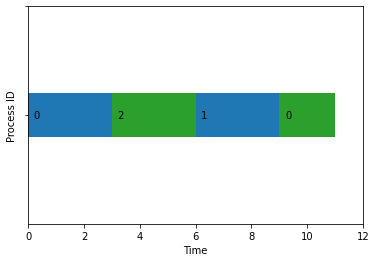

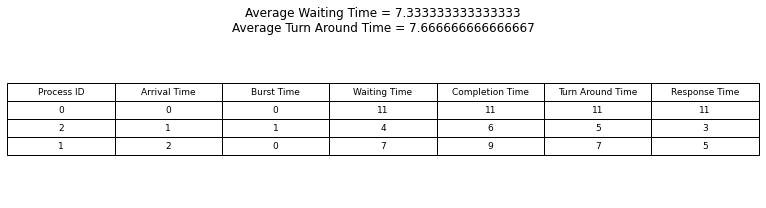

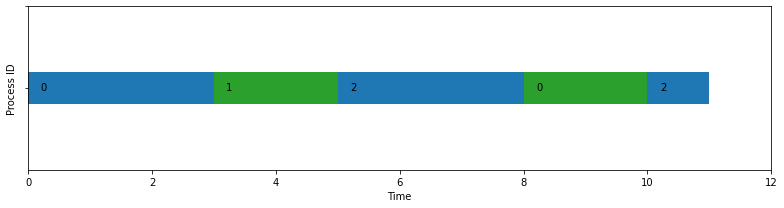

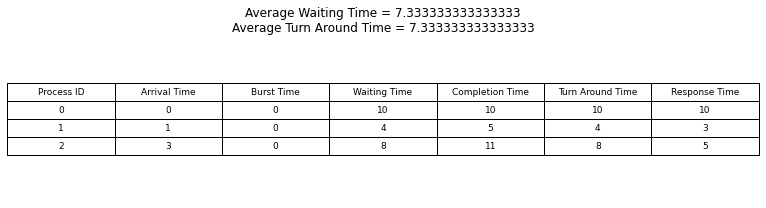

In [ ]:
# imports
import threading
import time

# Create an Event for notifying main thread.
callback_done = threading.Event()

# Create a callback on_snapshot function to capture changes
def on_snapshot(doc_snapshot, changes, read_time):
  for change in changes:
    # Check for a change in document
    if change.type.name == 'MODIFIED':
      # print(u'Change: {}'.format(change.document.id))
      # iterate through each document snapshot
      for doc in doc_snapshot:
        print(f'Received new document snapshot: {doc.id}')
        # initialize the input processes
        input = doc.to_dict()
        # print(input)
        inputProcesses = input['Processes']
        QUANTUM = input['Time Quantum']
        print(inputProcesses)
        print(QUANTUM)
        # dict containing the processes, gantt chart, average waiting time and average turn around time
        inputProcesses.sort(key=lambda process: process['Arrival Time']) # Timsort Algorithm TIME COMPLEXITY: O(nlogn)

        # create object of RoundRobin class and call it's method
        RoundRobin(processes = inputProcesses, QUANTUM = QUANTUM).simulate()

    # return the control to document watch
    callback_done.set()

# Watch the document
doc_watch = doc_ref.on_snapshot(on_snapshot)

# Keep the app running
while True:
    time.sleep(1)
    # print('watching')
